### Sentiment Analysis of the imdb Dataset using Bidirectional LSTM

#### Load Data
- Preprocess Text
- Clean Text
- Tokenize
- Split data to train and test set

#### Model Design
- Build Embeding Matrix
- Create Embeding Layer
- Model Network
- Train Model

#### Model Analysis
- Evalute Train Set
- Evaluate Test Set
- Visual Display

#### Sample reviews based on model

In [1]:
import numpy
import tqdm
import os
import codecs
import pandas as pd
import seaborn as sns

from keras.models import Model
from keras.layers import Conv1D, Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from keras.layers import Embedding, Input
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import numpy as np

#### Load Data


In [2]:
positive_dir = "aclImdb/train/pos"
negative_dir = "aclImdb/train/neg"

#### Preprocess Text


In [3]:
def read_text(filename):
    with codecs.open(filename, encoding='utf8') as f:
            return f.read().lower()

        
print ("Reading negative reviews.")
negative_text = [read_text(os.path.join(negative_dir, filename))
        for filename in tqdm.tqdm(os.listdir(negative_dir), ncols=10)]
        
    
print ("Reading positive reviews.")
positive_text = [read_text(os.path.join(positive_dir, filename))
        for filename in tqdm.tqdm(os.listdir(positive_dir), ncols=10)]


  0%| | 32

Reading negative reviews.


100%|█| 12
  0%| | 37

Reading positive reviews.


100%|█| 12


In [4]:
# declaration of variables
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 200 # 500
N_GLOVE_TOKENS = 400000
EMBEDDING_DIM = 100
epoch = 10

#### Clean Text


In [5]:
labels_index = { "negative": 0, "positive": 1 }

labels = [0 for _ in range(len(negative_text))] + \
        [1 for _ in range(len(negative_text))]
 
texts = negative_text + positive_text

#### Tokenize


In [6]:
# Tokenizer
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

#### Split data to train and test set

In [7]:
# Data Padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np_utils.to_categorical(np.asarray(labels))
print ("data.shape = {0}, labels.shape = {1}".format(data.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(data, labels)

data.shape = (25000, 200), labels.shape = (25000, 2)


#### Model Design
- Build Embeding Matrix

In [8]:
# Load word embeddings

print("Loading word embeddings.")
embeddings_index = dict()

with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in tqdm.tqdm(f, total=N_GLOVE_TOKENS):
        values = line.split()
        word, coefficients = values[0], np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefficients
       

  1%|▋                                                                        | 3817/400000 [00:00<00:10, 37526.48it/s]

Loading word embeddings.


100%|███████████████████████████████████████████████████████████████████████| 400000/400000 [00:10<00:00, 36813.49it/s]


In [9]:
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
print ("embedding_matrix.shape = {0}".format(embedding_matrix.shape))

embedding_matrix.shape = (88583, 100)


#### Model Network


In [10]:
# sequence model
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
emb_layer = Embedding(len(word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inputs)
lstm_layer = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(emb_layer)
output_layer = Dense(len(labels_index), activation="softmax")(lstm_layer)
model = Model(inputs, output_layer)


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          8858300   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 8,943,038
Trainable params: 84,738
Non-trainable params: 8,858,300
_________________________________________________________________


In [11]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["acc"])

#### Train Model



In [12]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=7, batch_size=64, verbose=1)

Epoch 1/7
293/293 [==============================] - 827s 3s/step - loss: 0.6346 - acc: 0.6183 - val_loss: 0.5047 - val_acc: 0.7582
Epoch 2/7
293/293 [==============================] - 818s 3s/step - loss: 0.4936 - acc: 0.7687 - val_loss: 0.4256 - val_acc: 0.8118
Epoch 3/7
293/293 [==============================] - 818s 3s/step - loss: 0.4237 - acc: 0.8078 - val_loss: 0.3825 - val_acc: 0.8363
Epoch 4/7
293/293 [==============================] - 805s 3s/step - loss: 0.3925 - acc: 0.8250 - val_loss: 0.3509 - val_acc: 0.8493
Epoch 5/7
293/293 [==============================] - 812s 3s/step - loss: 0.3555 - acc: 0.8440 - val_loss: 0.3323 - val_acc: 0.8581
Epoch 6/7
293/293 [==============================] - 825s 3s/step - loss: 0.3366 - acc: 0.8516 - val_loss: 0.3156 - val_acc: 0.8664
Epoch 7/7
293/293 [==============================] - 836s 3s/step - loss: 0.3184 - acc: 0.8627 - val_loss: 0.3122 - val_acc: 0.8709


#### Model Analysis
- Evaluate Test Set


In [13]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)

print()
print('Test Loss: {:.4f}'.format(loss))
print('Accuracy: {:.2f}%'.format(acc * 100))

196/196 [==============================] - 45s 229ms/step - loss: 0.3122 - acc: 0.8709

Test Loss: 0.3122
Accuracy: 87.09%


#### Visual Display

In [14]:
### training record
# print(history.history.keys())  ### dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

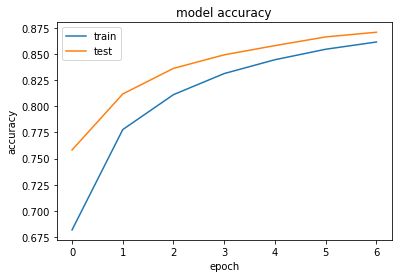

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

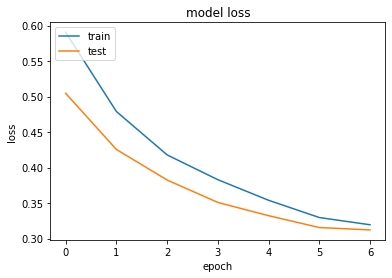

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Sample reviews based on model

In [20]:
sentiment = ['Negative','Positive']

In [22]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]


'Positive'

In [23]:
sequence = tokenizer.texts_to_sequences(['Python is neither bad nor good, just there'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]


'Negative'